## Enviroment Setup

In [1]:
import argparse
import numpy as np
import torch
import torch.optim as optim
from torch_geometric.data import Data
from gnn_disease.utils import *
from gnn_disease.model import *
from gnn_disease.model_g_encoder import *
from gnn_disease.model_kg_encoder import *
from gnn_disease.trainer import Trainer

/Users/fanyimin/miniconda3/envs/cogo/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/fanyimin/miniconda3/envs/cogo/lib/python3.9/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: 
object has no attribute sparse_csc_tensor:
  File "/Users/fanyimin/miniconda3/envs/cogo/lib/python3.9/site-packages/torch_sparse/tensor.py", line 585
            value = torch.ones(self.nnz(), dtype=dtype, device=self.device())
    
        return torch.sparse_csc_tensor(colptr, row, value, self.sizes())
               ~~~~~~~~~~~~~~~~~~~~~~~ <--- HERE

  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


## Setup hyperparameters and configurations for the code

In [2]:
parser = argparse.ArgumentParser(description="PyTorch JCLModel")
parser.add_argument("--data", default="./data", help="path to dataset")
parser.add_argument("--h_dim", default=32, type=int, help="dimension of layer h")
parser.add_argument("--z_dim", default=32, type=int, help="dimension of layer z")
parser.add_argument("--tau", default=1.0, type=float, help="softmax temperature")
parser.add_argument("--lr", default=0.003, type=float, help="learning rate")
parser.add_argument("--epochs", default=20, type=int, help="train epochs")
parser.add_argument(
    "--disable-cuda", default=True, action="store_true", help="disable CUDA"
)
parser.add_argument(
    "--log-every-n-steps", default=1, type=int, help="log every n steps"
)
parser.add_argument("--g_name", default="GCN", type=str, help="log every n steps")
parser.add_argument("--kg_name", default="RGCN", type=str, help="log every n steps")

args = parser.parse_known_args()[0]

device = torch.device(
    "cuda" if not args.disable_cuda and torch.cuda.is_available() else "cpu"
)

## Load dataset

In [3]:
# Load knowledge graph statistics
with open(args.data + "/entity2id.txt", "r") as f:
    num_ents = (int)(f.readline())
with open(args.data + "/relation2id.txt", "r") as f:
    num_rels = (int)(f.readline())

There are 43987 genes involved in total for the analysis and 9 types of relationships in the GO Database

In [4]:
## Number of Gene entities in the graph
num_ents

43987

In [5]:
## Number of gene relationships in the graph (we only count unique relationships)
num_rels

9

In [6]:
# Load GO knowledge graph 
train_triples = load_triples(args.data)
edge_index, edge_type = get_kg_data(train_triples, num_rels)
kg_data = Data(edge_index=edge_index, edge_type=edge_type, num_nodes=num_ents)

GO(90185) datasets loaded.


There are 43986 entities in this dataset in total, and there are 180370 relationships 
We show an example here on how the data is stored. The edge index stores the source and destination of all relationships. The shape of edge index is (2,180370). And the train triples contain 90185 tuples for training, which is reasonable becuase each relationship will be stored twice 180370/2=90185. The tuple in train triples contain three elements, the first is source, the second is relation type and the third is destination

In [7]:
print(len(train_triples))
print(edge_index.shape[1])
print(edge_index[:,0:10])
print(train_triples[0:10])

90185
180370
tensor([[    0,     1,     2,     3,     3,     4,     5,     6,     7,     7],
        [28837, 29194, 28780, 35250, 28128, 28833, 19962,  9011,  6711, 19094]])
[(0, 0, 28837), (1, 0, 29194), (2, 0, 28780), (3, 0, 35250), (3, 0, 28128), (4, 0, 28833), (5, 0, 19962), (6, 0, 9011), (7, 0, 6711), (7, 0, 19094)]


In [8]:
# Load human net for GCN Model
hnadj = load_sparse(args.data + "/hnet.npz")
src = hnadj.row
dst = hnadj.col
hn_edge_weight = torch.tensor(np.hstack((hnadj.data, hnadj.data)), dtype=torch.float)
hn_edge_weight = (hn_edge_weight - hn_edge_weight.min()) / (
    hn_edge_weight.max() - hn_edge_weight.min()
)
hn_edge_index = torch.tensor(
    np.vstack((np.concatenate([src, dst]), np.concatenate([dst, src]))),
    dtype=torch.long,
)


For the humannet dataset, there are totally 371571 relationships in this dataset across 17247 genes

In [9]:
print(len(src))
print(len(dst))
print(hnadj.shape)

371501
371501
(17247, 17247)


g2o means the alignment between humannet database and Go database, the relationship is represented as a sparse matrix.  It is possible that a gene in one dataset corresponds to multiple genes in another dataset. So the sum of g2o matrix is larger than the total number of genes
d2g means the alignment between disease and genes. the relationship is also represented as a sparse matrix. There are 30170 types of disease in total. One disease may correspond to one gene or multiple genes.
 

In [10]:
# Load gene2GO align
g2o = load_sparse(args.data + "/g2o.npz")
g2o = mx_to_torch_sparse_tesnsor(g2o).to_dense()

x = generate_sparse_one_hot(g2o.shape[0])
g_data = Data(x=x, edge_index=hn_edge_index, edge_weight=hn_edge_weight)

d2g = load_sparse(args.data + "/d2g.npz")
d2g = mx_to_torch_sparse_tesnsor(d2g)

In [11]:
print(g2o.shape)
print(torch.sum(g2o,dim=1).shape)
print(torch.sum(g2o,dim=1))
print(d2g.shape)
print(torch.sum(d2g.to_dense(),dim=1))

torch.Size([17247, 43987])
torch.Size([17247])
tensor([ 1., 10., 17.,  ..., 41., 13., 61.])
torch.Size([30170, 17247])
tensor([1.9400e+02, 9.0000e+00, 2.0440e+03,  ..., 1.0000e+00, 1.0000e+00,
        1.0000e+00])


## Initialization of model

In [12]:

if args.g_name == "GCN":
    g_encoder = GCN(nfeat=g_data.x.shape[1], nhid=args.h_dim)
elif args.g_name == "EG":
    g_encoder = EG(nfeat=g_data.x.shape[1], nhid=args.h_dim)
elif args.g_name == "GAT":
    g_encoder = GAT(nfeat=g_data.x.shape[1], nhid=args.h_dim)
elif args.g_name == "GATv2":
    g_encoder = GATv2(nfeat=g_data.x.shape[1], nhid=args.h_dim)
elif args.g_name == "GraphGEN":
    g_encoder = GraphGEN(nfeat=g_data.x.shape[1], nhid=args.h_dim)
else:
    raise NotImplementedError
if args.kg_name == "FastRGCN":
    kg_encoder = FastRGCN(num_nodes=num_ents, nhid=args.h_dim, num_rels=num_rels * 2)
elif args.kg_name == "RGATConvNet":
    kg_encoder = RGATConvNet(num_nodes=num_ents, nhid=args.h_dim, num_rels=num_rels * 2)
elif args.kg_name == "RGCN":
    kg_encoder = RGCN(num_nodes=num_ents, nhid=args.h_dim, num_rels=num_rels * 2)
projection = Projection(args.h_dim, args.z_dim)
model = GNNDisease(g_encoder, kg_encoder, projection)
opt = optim.RMSprop(model.parameters(), args.lr)
trainer = Trainer(
    model,
    tau=args.tau,
    optimizer=opt,
    log_every_n_steps=args.log_every_n_steps,
    device=device,
    name=args.g_name + "-" + args.kg_name,
)
trainer.load_data(g_data, kg_data, g2o, d2g, args.data)

## Train and test the model

In [13]:
trainer.train(args.epochs)

Start JCLModel training for 20 epochs.


Loss 6.7493: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


AUROC: 83.03623611922852 | AUPRC: 76.44462183277393


## Visualize the AUPRC/AUROC curve

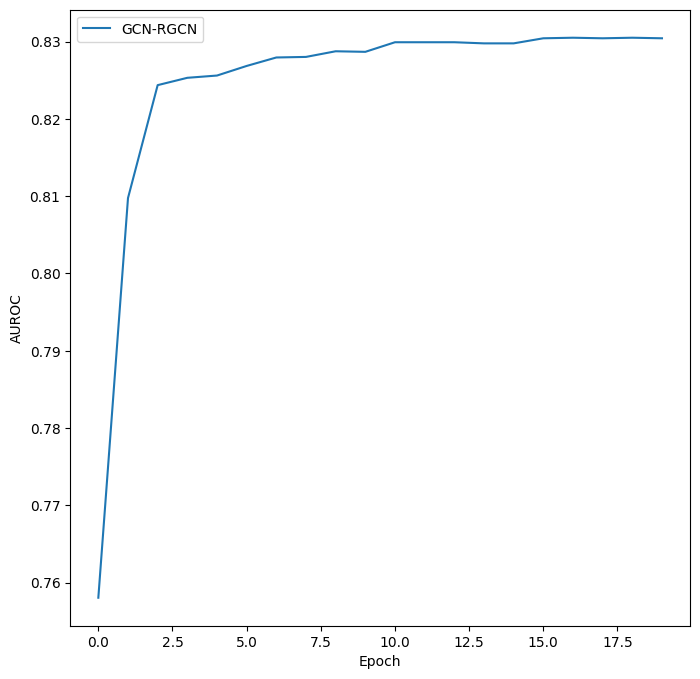

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8,8))

with open("runs/" + args.g_name+ "-" + args.kg_name + "/training.log") as f:
    AUROC_all = []
    epoch = []
    count = 0
    for line in f:
        if "Epoch" in line:
            item = line.split("\t")
            AUROC = float(item[2].split(" ")[1])
            AUROC_all.append(AUROC)
            epoch.append(count)
            count = count + 1
    sns.lineplot(x=np.array(epoch), y=np.array(AUROC_all), label = args.g_name + "-" + args.kg_name)
    plt.xlabel("Epoch")
    plt.ylabel("AUROC")
    plt.show()